# PRICING AND HEDGING - Lista 2

## Exercício 3:

Usem as primeiras 20 trilhas e gerem o breakeven smile para cada uma dessas trajetórias (usem 5 strikes para cada smile, -10 delta, -25 delta, ATM, 25 delta, 10 delta). Algo a observar?
    

## Using methods from exercise 2

In [2]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

%matplotlib inline

def ca(x, size):
    y = np.empty(size)
    y.fill(x)
    return y

def ppzero(s):
    return pd.Series(pd.Series.append(pd.Series([0]), s).values)

def mcpath(nsteps, S0, drift, vol, t):
    # Generates nsteps random numbers N(0, 1)
    nmdr = pd.Series(np.random.standard_normal(nsteps))
    # Time discretization
    dt = t/nsteps
    # Create an array of dt
    ts = pd.Series(ca(dt, nsteps))
    # Include initial t0
    ts0 = ppzero(ts)
    s1 = (drift - pow(vol, 2)/2) * dt
    s2 = vol * np.sqrt(dt)
    # Steps = Sum of two vectors
    steps = s1 * pd.Series(ca(1, nsteps)) + s2 * nmdr
    steps0 = ppzero(steps)
    # Accumulate
    cmsteps = steps0.cumsum()
    cmts = ts0.cumsum()
    # Convert steps to path
    Sj = S0 * np.exp( cmsteps.values )
    # create timeseries [t,St]
    path=pd.Series(Sj, index=cmts.values)
    
    return path

def mcpaths(npaths, nsteps, S0, drift, vol, t):
    # generate npaths using mcpath
    paths=[mcpath(nsteps, S0, drift, vol, t) for j in range(npaths)]
    return paths

def bsv(phi, S, K, r, q, vol, t):
    if (t > 0):
        fwd=S*np.exp((r-q)*t)
        efv=t*(vol**2)
        # calculate d1 and d2
        d1=(np.log(fwd/K)+(efv/2))/(np.sqrt(efv))
        d2=(np.log(fwd/K)-(efv/2))/(np.sqrt(efv))
        # calculate N(d1) and N(d2)
        Nd1=st.norm.cdf(phi*d1)
        Nd2=st.norm.cdf(phi*d2)
        # calculate premium
        pr=phi*S*np.exp(-q*t)*Nd1-phi*K*np.exp(-r*t)*Nd2
        # calculate delta
        de=phi*np.exp(-q*t)*Nd1
    else:
        de = 0
        if (phi == 1):
            pr = max(S-K, 0)
        else:
            pr = max(K-S, 0)
        
    return [pr, de]

def calcpath(path, phi, K ,r, q, vol, T):
    ttm=T-path.index
    bsvpath=np.array([[path.index[j], path.values[j]] + bsv(phi, path.values[j], K, r, q, vol, ttm[j])\
                      for j in range(len(path))])

    return pd.DataFrame(bsvpath,columns=['time','spot','premium','delta'])

def filldf(path, phi, K, r, q, vol, T):
    nstp=len(path)-1
    # calculate t,S(t),premium(t),delta(t)
    df=calcpath(path, phi, K, r, q, vol, T)
    # cashflows for the option
    df['cfwprem']=0
    df.loc[0,'cfwprem']=-df['premium'][0]
    df.loc[nstp,'cfwprem']=df['premium'][nstp]
    df.loc[nstp,'premium']=0
    # calculate time intervals dt
    df['timechg']=df['time'].diff()
    df.loc[0,'timechg']=0
    # calculate changes in delta
    df.loc[nstp,'delta']=0
    df['dltchg']=df['delta'].diff()
    df.loc[0,'dltchg']=0
    # calculate changes in spot price
    df['spotchg']=df['spot'].diff()
    df.loc[0,'spotchg']=0
    # cashflows for the asset
    df['cfwspot']=0
    df.loc[0,'cfwspot']=df['delta'][0]*df['spot'][0]
    df.loc[1:,'cfwspot']=df['dltchg'][1:]*df['spot'][1:]
    # dividend cashflows
    df['cfwdivid']=0
    df.loc[1:,'cfwdivid']=-((df['delta'][0:nstp]*df['spot'][0:nstp]).values)*(np.exp(q*df['timechg'][1:].values)-1)
    # cashflows before interest
    df['cfwprer']=df['cfwprem']+df['cfwspot']+df['cfwdivid']
    # interest and consolidation of cashflows
    df['balance']=0
    df.loc[0,'balance']=df['cfwprer'][0]
    for j in range(1,nstp+1):
        df.loc[j,'balance']=df['balance'][j-1]*(np.exp(r*df['timechg'][j]))+df['cfwprer'][j]
    # portfolio
    df['portf']=df['premium']-df['delta']*df['spot']+df['balance']
    # consolidated discount factor
    return df

def portfolio(path, phi, K, r, q, vol, T):
    fulldf=filldf(path, phi, K, r, q, vol, T)
    return pd.Series(fulldf['portf'].values)

def finalpl(vol, path, phi, K, r, q, T):
    portf=portfolio(path, phi, K, r, q, vol, T)
    return portf[len(path)-1]

## Running the exercise

In [3]:
call = 1
put = -1
S0 = 100
K = 100
actualVol = 0.30
impliedVol = 0.20
T = 1
q = 0
r = 0
numPaths = 500
numSteps = 500
phi = call

paths = mcpaths(numPaths, numSteps, S0, r-q, actualVol, T)

First we need to find the strikes related to each delta (-10 delta, -25 delta, ATM, 25 delta, 10 delta):

In [4]:
def getStrikeByDelta(phi, delta, S, r, q, vol, t):
    return S * np.exp(phi* st.norm.ppf(delta * np.exp((r-q)*t)) * vol * np.sqrt(t) + ((vol**2)/2) * t)   

In [5]:
strikeDeltaMinus10 = getStrikeByDelta(put, 0.10, S0, r, q, impliedVol, T)
strikeMinus25 = getStrikeByDelta(put, 0.25, S0, r, q, impliedVol, T)
strikeATM = S0
strikePlus25 = getStrikeByDelta(call, 0.25, S0, r, q, impliedVol, T)
strikePlus10 = getStrikeByDelta(call, 0.10, S0, r, q, impliedVol, T)

strikes = [strikeDeltaMinus10, strikeMinus25, strikeATM, strikePlus25, strikePlus10]
strikes

[131.82568729522069,
 116.75388077358872,
 100,
 89.145711242844911,
 78.95356326582359]

Find Break Even Smile of path using Newthon method for each strike:

In [6]:
import scipy.optimize as opt

def bevSmilesByPath(path, phi, strikes, r, q, vol, T):
    r = pd.Series(np.array([opt.newton(finalpl, vol, args=(path, phi, K, r, q, T)) for K in strikes]), index=strikes)
    return r

In [8]:
testPath0 = bevSmilesByPath(paths[0], call, strikes, r, q, actualVol, T)
testPath0

131.825687    0.293686
116.753881    0.282315
100.000000    0.288283
89.145711     0.292171
78.953563     0.294331
dtype: float64

Find Break Even Smiles for the first twentieth paths:

In [9]:
def bevSmilesByPaths(paths, phi, strikes, r, q, vol, T):
    r = pd.DataFrame([bevSmilesByPath(path, phi, strikes, r, q, vol, T) for path in paths])
    return r

In [10]:
bevSmiles = bevSmilesByPaths(paths[:20], call, strikes, r, q, actualVol, T)

Plot Break Even Smiles:

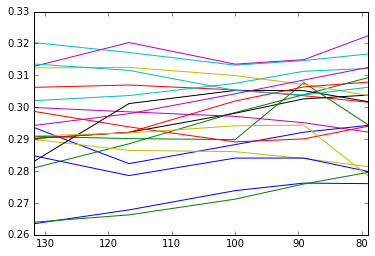

In [11]:
bevSmiles.transpose().plot(legend=False)